# Testing HW equilibrium

- Initial population: 10000
- Fertility rate: 2.0
- Replicates per scenario: 100
- Random mating parameters being explored: 1, 0.3, 0
- Allele frequency = 0.45 - 0.55
- I am using previous restriction: reproduction time (35 years), no mixing between siblings and cousins 

In [123]:
library(data.table)
library(lfa)
library(ggplot2)
library(patchwork)
library(HardyWeinberg)
output_path = "../output/data/"
nrep = 10

In [124]:
# read data
dat = fread(paste0(output_path, "agents-snp-hw.csv"))
params = fread(paste0(output_path, "param-snp-hw.csv"))
rr = fread(paste0(output_path, "results-snp-hw.csv"))
# create id
dat[, id := .GRP, .(iteration, replicate)]


In [125]:
# final population
summary(rr$population)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  23287   28151   29785   30616   33320   38336 

In [126]:
table(dat$generation)


     0     10     30     50 
600000 443065 441737 458628 

In [127]:
# snp text to numeric
vars = paste0("snp", 0:99)
dat[, agent_id := 1:.N]
dat[, (vars) := tstrsplit(snps, ",", fixed=TRUE)]
dat[, (vars) := lapply(.SD, function(x) factor(as.numeric(gsub(".+=|\\}", "", x)), levels = 0:2)), .SDcols = vars]
df = merge(dat, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))
rr = merge(rr, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))

In [108]:
# prop.table(table(dat[generation == 0, snp2]))
# prop.table(table(dat[generation == check_generation, snp2]))

In [130]:
# testing transformation from snp text to columns
ss = sample(nrow(dat), 1)
dat[ss, snps]
dat[ss, ..vars]

[1] "{0=0.0, 1=0.0, 2=0.0, 3=1.0, 4=2.0, 5=1.0, 6=1.0, 7=0.0, 8=2.0, 9=1.0, 10=2.0, 11=0.0, 12=0.0, 13=1.0, 14=1.0, 15=1.0, 16=0.0, 17=0.0, 18=0.0, 19=1.0, 20=2.0, 21=2.0, 22=1.0, 23=2.0, 24=1.0, 25=0.0, 26=1.0, 27=1.0, 28=0.0, 29=0.0, 30=1.0, 31=2.0, 32=2.0, 33=1.0, 34=2.0, 35=1.0, 36=1.0, 37=1.0, 38=1.0, 39=1.0, 40=1.0, 41=2.0, 42=1.0, 43=1.0, 44=1.0, 45=1.0, 46=1.0, 47=2.0, 48=0.0, 49=1.0, 50=1.0, 51=2.0, 52=1.0, 53=1.0, 54=2.0, 55=1.0, 56=1.0, 57=2.0, 58=1.0, 59=2.0, 60=1.0, 61=1.0, 62=1.0, 63=1.0, 64=0.0, 65=1.0, 66=2.0, 67=1.0, 68=2.0, 69=1.0, 70=0.0, 71=1.0, 72=0.0, 73=1.0, 74=1.0, 75=1.0, 76=1.0, 77=0.0, 78=0.0, 79=1.0, 80=0.0, 81=0.0, 82=0.0, 83=2.0, 84=1.0, 85=1.0, 86=1.0, 87=0.0, 88=2.0, 89=1.0, 90=1.0, 91=1.0, 92=2.0, 93=2.0, 94=1.0, 95=0.0, 96=1.0, 97=1.0, 98=1.0, 99=0.0}"

snp0,snp1,snp2,snp3,snp4,snp5,snp6,snp7,snp8,snp9,...,snp90,snp91,snp92,snp93,snp94,snp95,snp96,snp97,snp98,snp99
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0,0,0,1,2,1,1,0,2,1,...,1,1,2,2,1,0,1,1,1,0


In [129]:

# standard function to test HW
getHWsnps = function(data, idvar = "id", snps = paste0("snp", 0:99)) {
    ids = unique(data[[idvar]])
    pvalues = NULL
    for (i in ids) {
        temp = copy(data[get(idvar) == i])
        for (ii in snps) {
            t = table(temp[, get(ii)])
            allele = c("AA", "AB", "BB")
            t = as.vector(t)
            names(t) = allele
            pvalues = c(pvalues, HWChisq(t, verbose = FALSE)$pval)
        }
    }
    return(pvalues)
}

# This function is computationally expensive
getHWpvalues = function(data, idvar = "id", k = 1, nsample = NULL) {
    ids = unique(data[[idvar]])
    pvalues = NULL
    vars = names(data)[grepl("^snp[0-9]+$", names(data))] 
    for (i in ids) {
        temp = copy(data[id == i, ..vars])
        m = as.matrix(transpose(temp))
        # use k=1 for standard HW test
        LF = lfa(m, k)
        pvalues = c(pvalues, sHWE(m, LF, 4))
    }
    print(summary(pvalues))
    return(pvalues)
}

# Assortative mating (BMI)


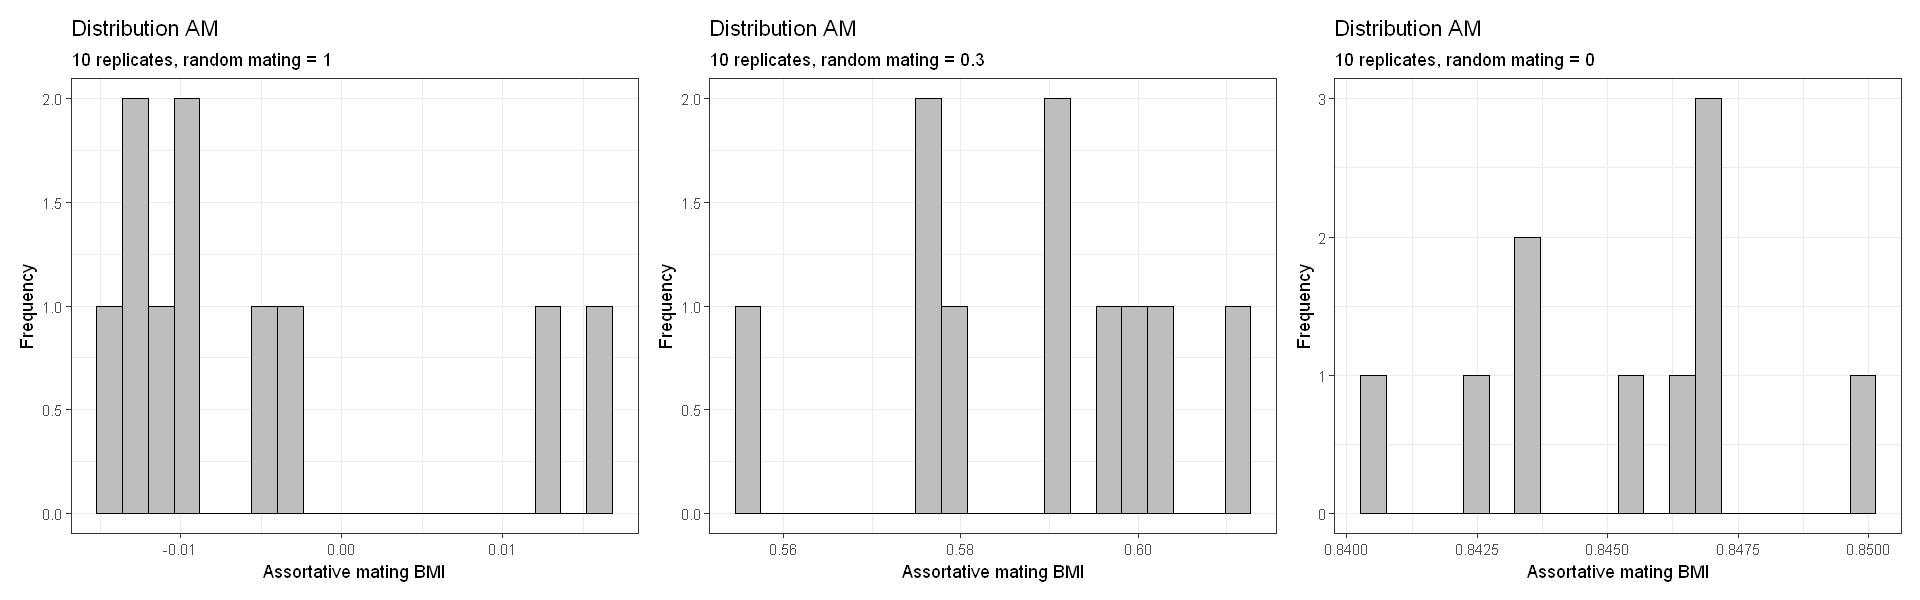

In [131]:
options(repr.plot.width=16, repr.plot.height=5)
plots = list() 
values = c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(rr[random_mating == values[i], .(am_bmi)], aes(am_bmi)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "Assortative mating BMI", y = "Frequency", 
    title = "Distribution AM", 
        subtitle = paste0(nrep, " replicates, random mating = ", values[i]))
}
wrap_plots(plots)

# Contrasting generations

## Generation 0 

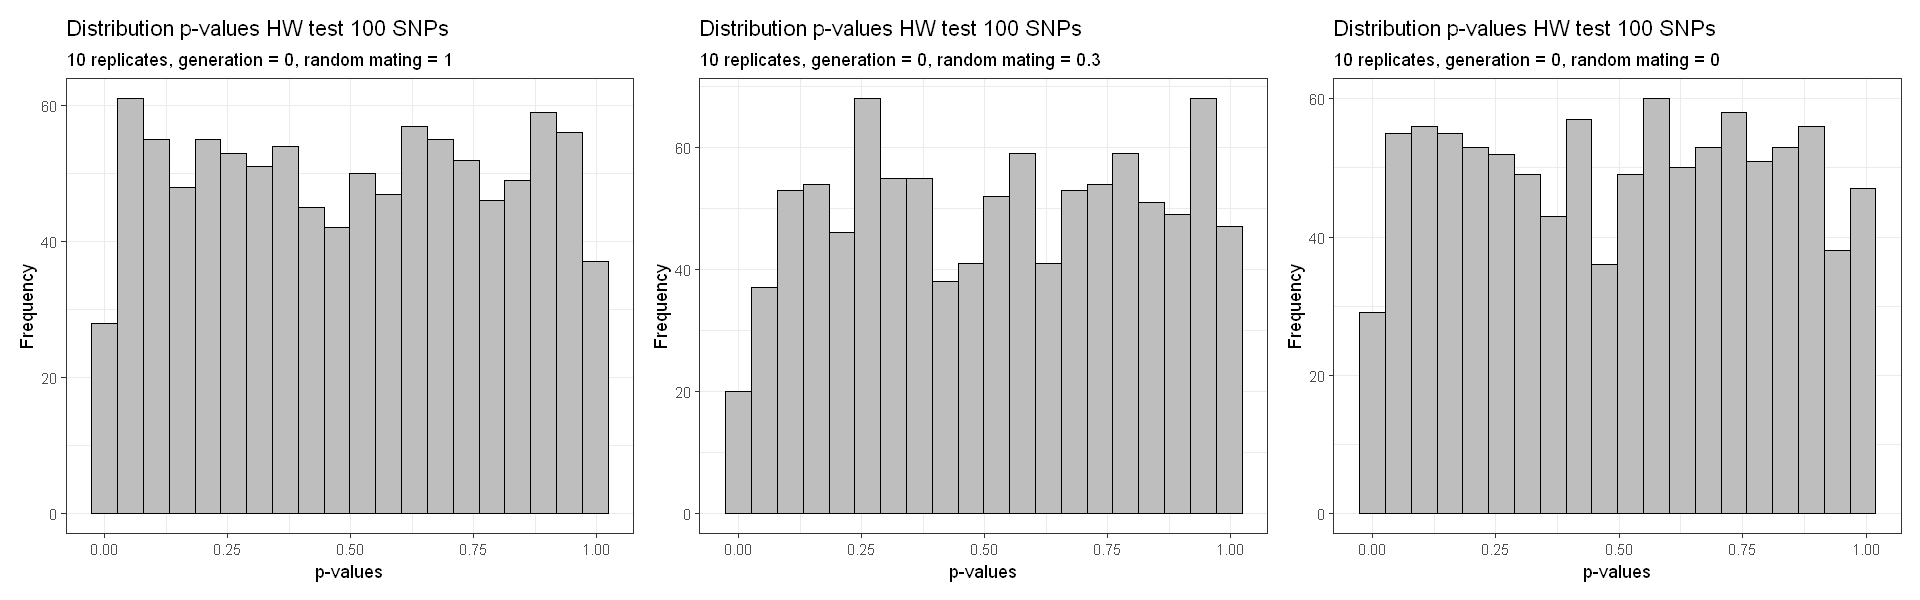

In [132]:
check_generation = 0
pvalues0rm0 = getHWsnps(df[generation == 0 &  random_mating == 0])
pvalues0rm03 = getHWsnps(df[generation == 0 &  random_mating == 0.3])
pvalues0rm1 = getHWsnps(df[generation == 0 &  random_mating == 1])

plots = list() 
vars = c("pvalues0rm1", "pvalues0rm03", "pvalues0rm0") 
values =  c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = ", check_generation, ", random mating = ", values[i]))
}
wrap_plots(plots)

## Generation 10

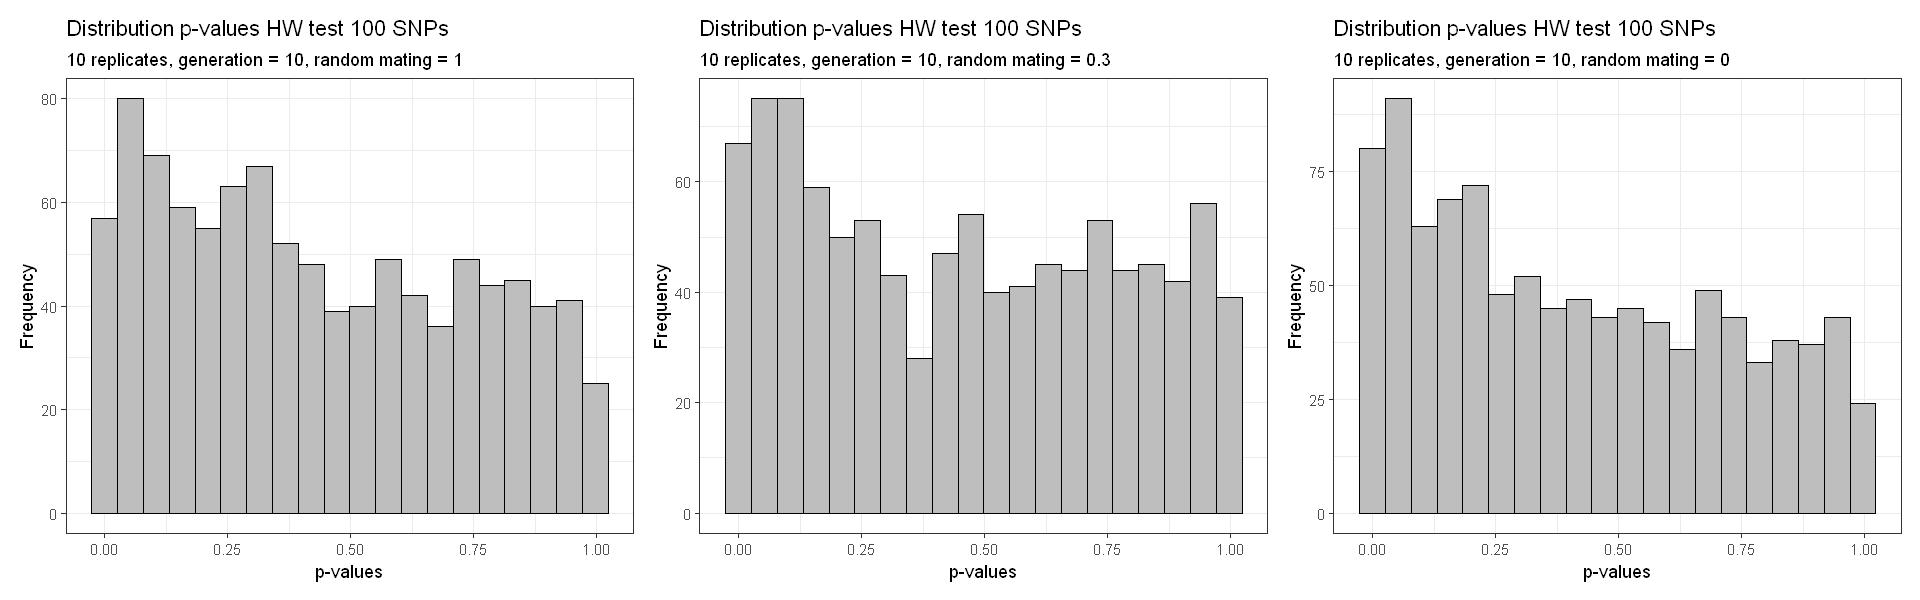

In [133]:
check_generation = 10
pvalues1rm0 = getHWsnps(df[generation == check_generation &  random_mating == 0])
pvalues1rm03 = getHWsnps(df[generation == check_generation &  random_mating == 0.3])
pvalues1rm1 = getHWsnps(df[generation == check_generation &  random_mating == 1])


plots = list() 
vars = c("pvalues1rm1", "pvalues1rm03", "pvalues1rm0") 
values =  c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = ", check_generation, ", random mating = ", values[i]))
}
wrap_plots(plots)

## Generation 30

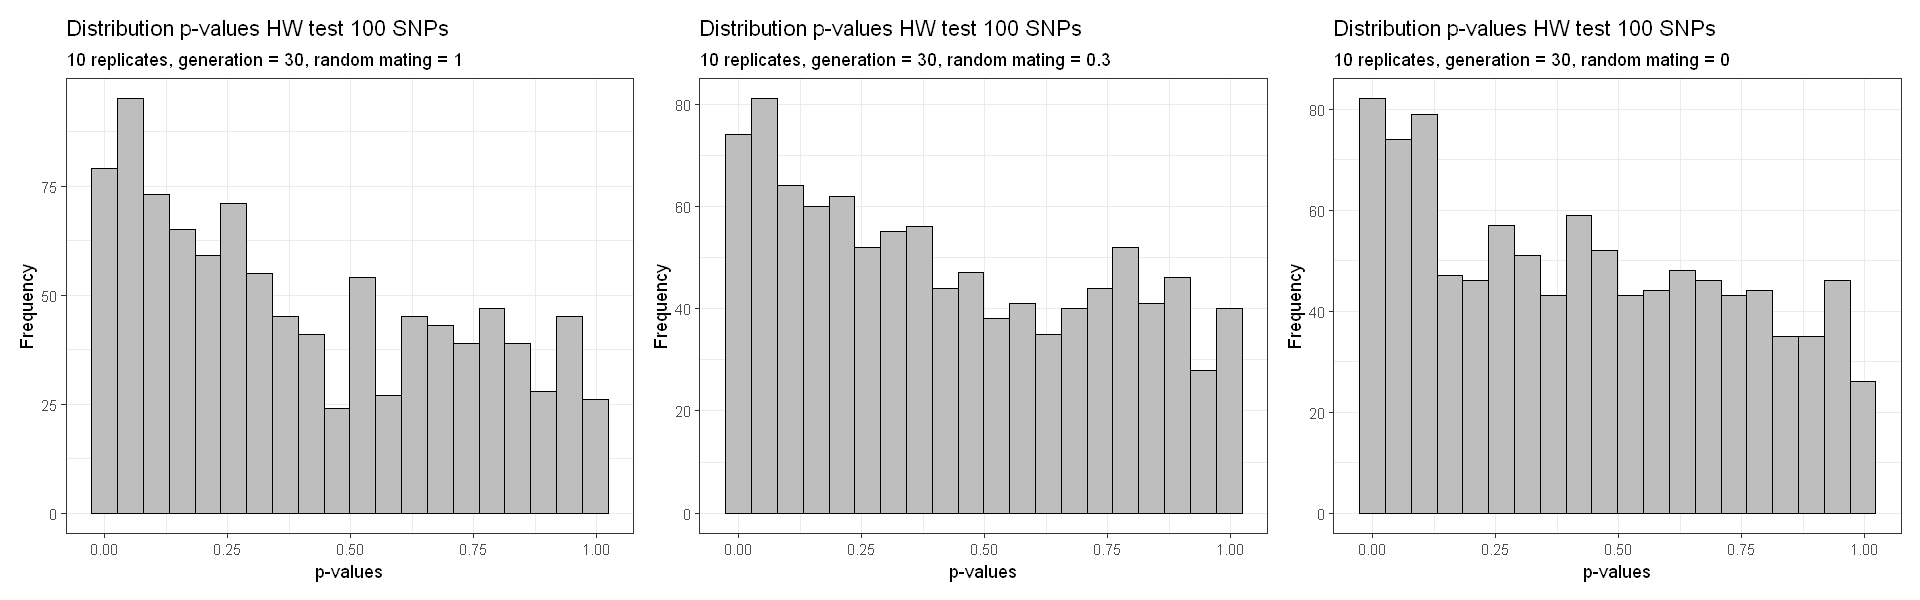

In [135]:
check_generation = 30
pvalues1rm0 = getHWsnps(df[generation == check_generation &  random_mating == 0])
pvalues1rm03 = getHWsnps(df[generation == check_generation &  random_mating == 0.3])
pvalues1rm1 = getHWsnps(df[generation == check_generation &  random_mating == 1])


plots = list() 
vars = c("pvalues1rm1", "pvalues1rm03", "pvalues1rm0") 
values =  c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = ", check_generation, ", random mating = ", values[i]))
}
wrap_plots(plots)

# Generation 50

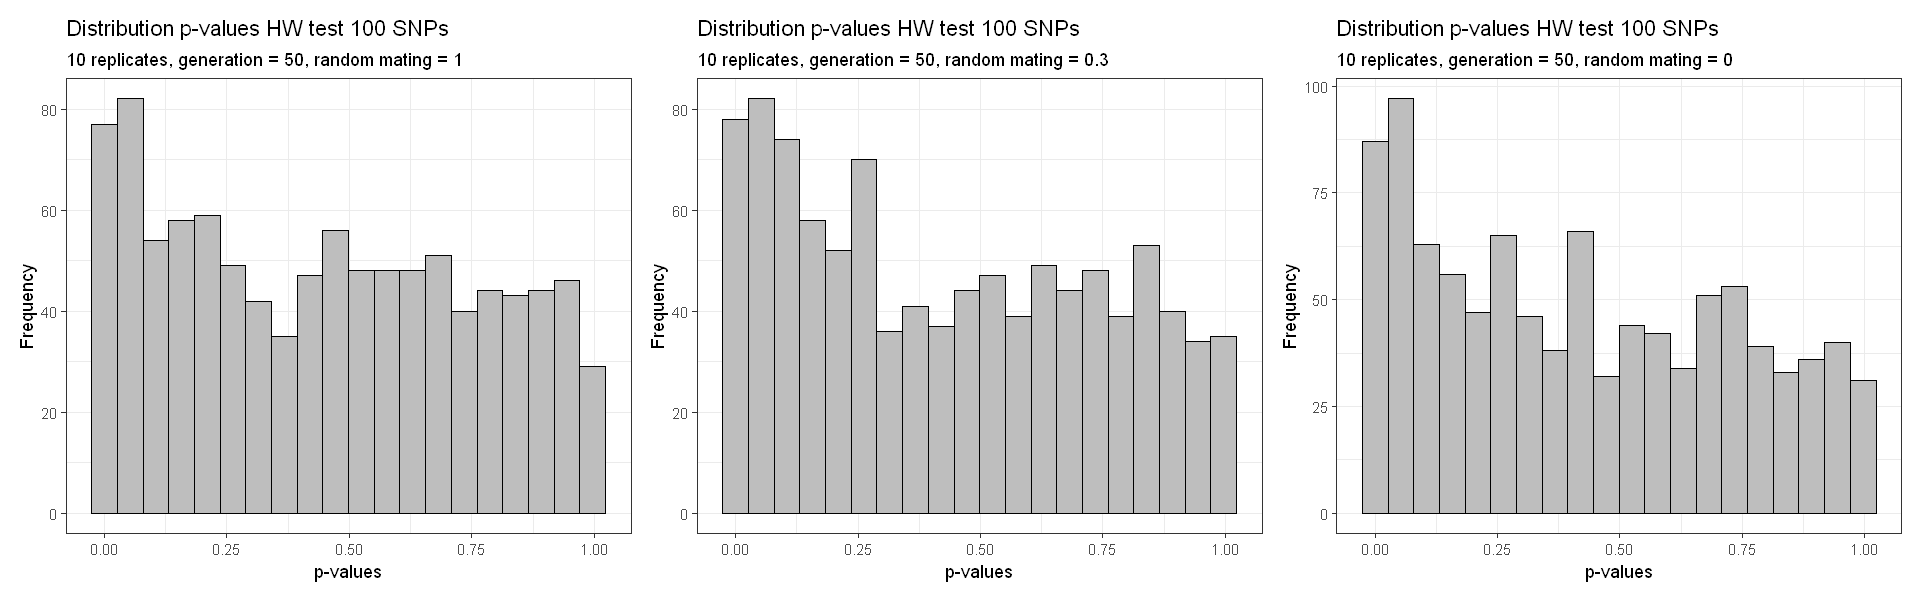

In [136]:
check_generation = 50
pvalues1rm0 = getHWsnps(df[generation == check_generation &  random_mating == 0])
pvalues1rm03 = getHWsnps(df[generation == check_generation &  random_mating == 0.3])
pvalues1rm1 = getHWsnps(df[generation == check_generation &  random_mating == 1])


plots = list() 
vars = c("pvalues1rm1", "pvalues1rm03", "pvalues1rm0") 
values =  c(1, 0.3, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = ", check_generation, ", random mating = ", values[i]))
}
wrap_plots(plots)